In [128]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
from google.colab import files
from IPython.display import Image
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image 

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

In [129]:
input = files.upload()

Saving Sagittal T1.jpg to Sagittal T1 (1).jpg


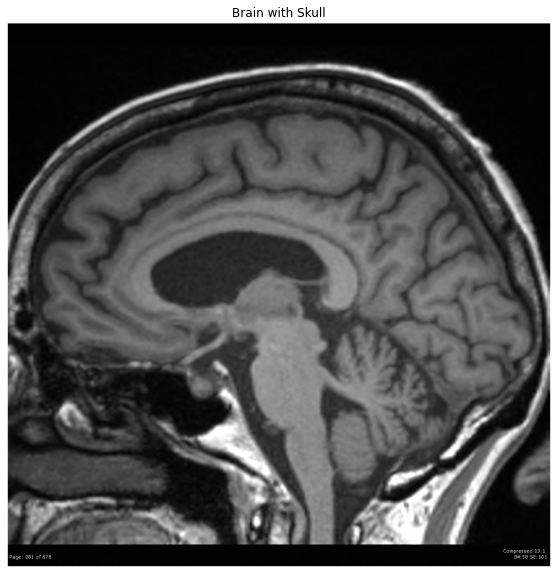

In [130]:
img           = cv2.imread('Sagittal T1 (1).jpg')
gray          = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Brain with Skull',gray,'gray')

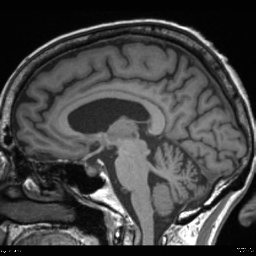

In [131]:

bigger = cv2.resize(gray, (256, 256))
cv2_imshow(bigger)

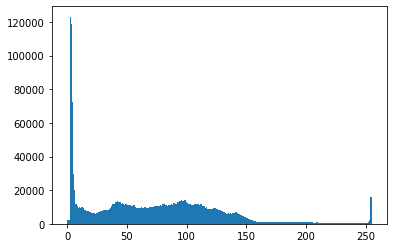

In [132]:
#Make a histogram of the intensities in the grayscale image
plt.hist(gray.ravel(),256)
plt.show()

(Text(0.5, 1.0, 'Magnitude Spectrum'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

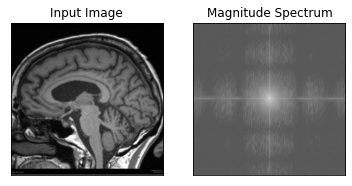

In [133]:
# Blur the grayscale image by a Guassian filter with kernel size of 10
imBlur = cv2.blur(gray,(5,5))
# Transform the image to frequency domain
f = np.fft.fft2(imBlur)
# Bring the zero-frequency component to the center
fshift = np.fft.fftshift(f)
magnitude_spectrum = 30*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(imBlur, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'Image after HPF'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

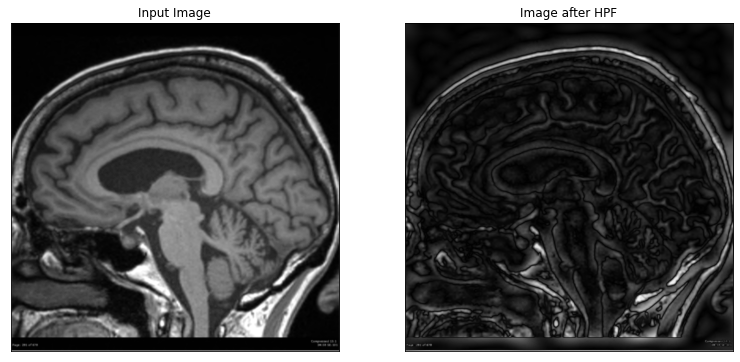

In [134]:
rows, cols = imBlur.shape
crow,ccol = round(rows/2) , round(cols/2)
# remove low frequencies with a rectangle size of 10
fshift[crow-10:crow+10, ccol-10:ccol+10] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(figsize=([20, 20]))
plt.subplot(131),plt.imshow(imBlur, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
#plt.subplot(133),plt.imshow(img_back)
#plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
#plt.show()

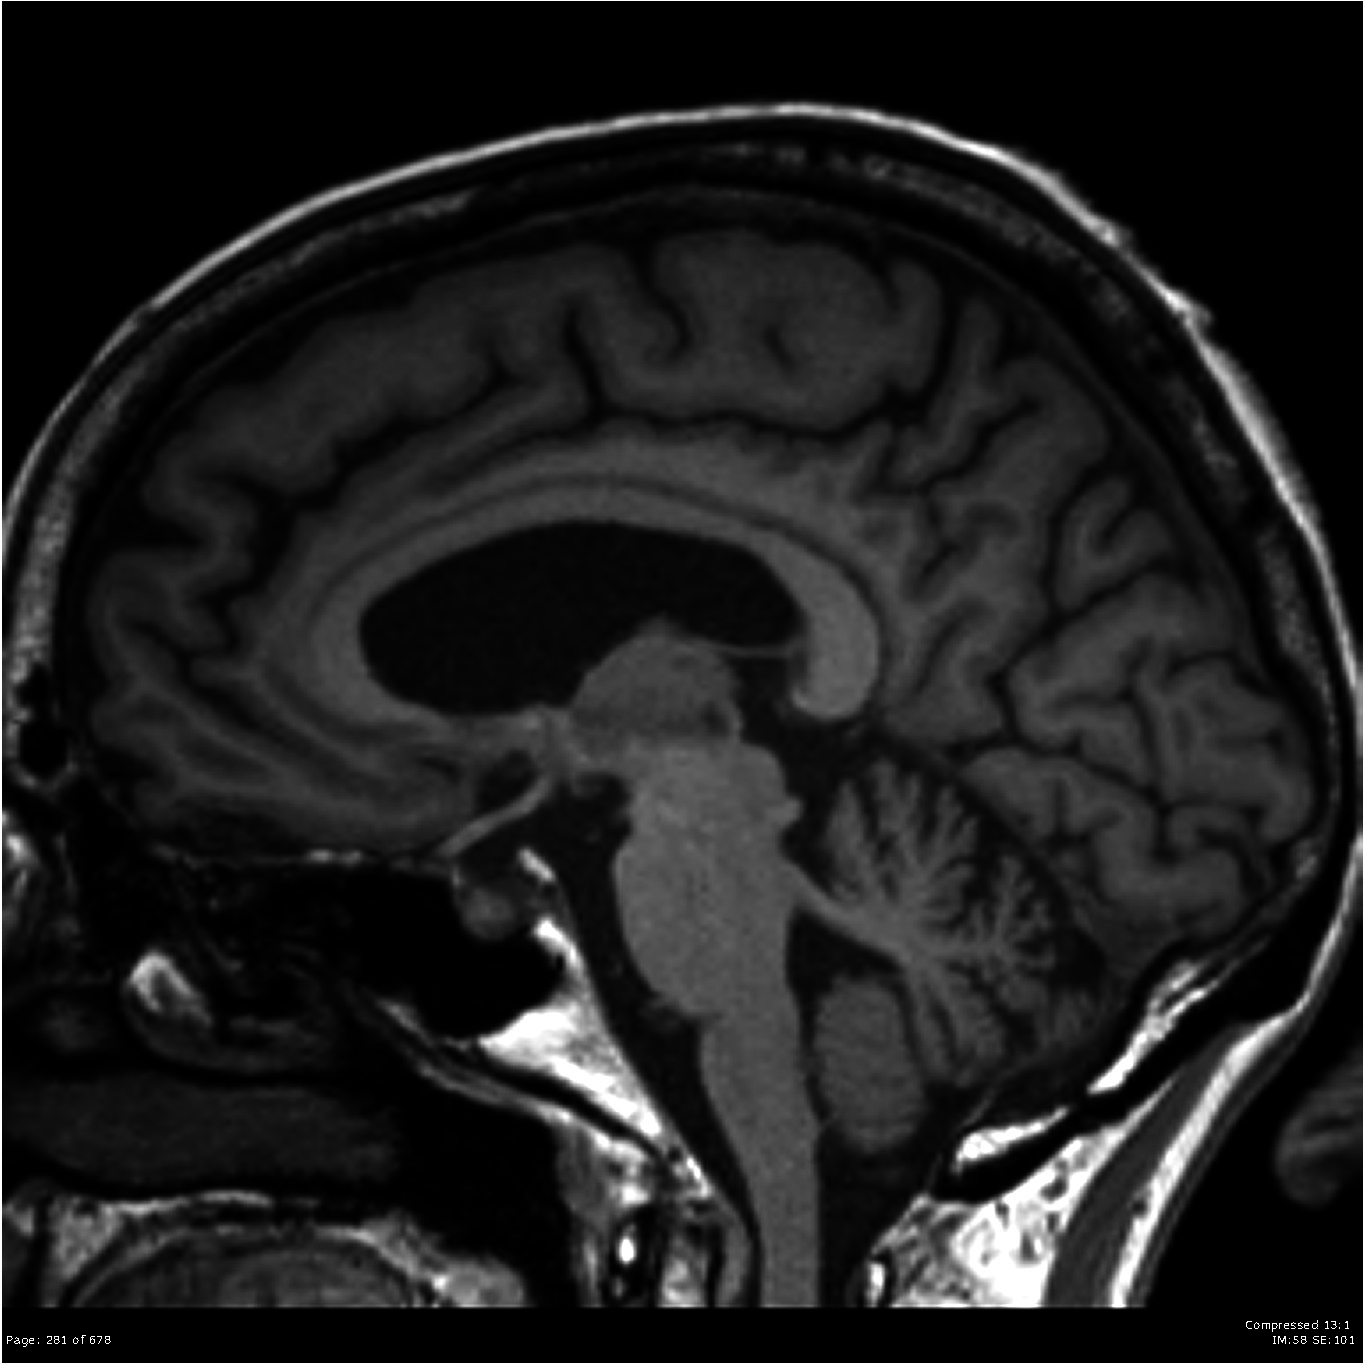

In [136]:
im4 = 255.0*(gray/255.0)**2
cv2_imshow(im4)

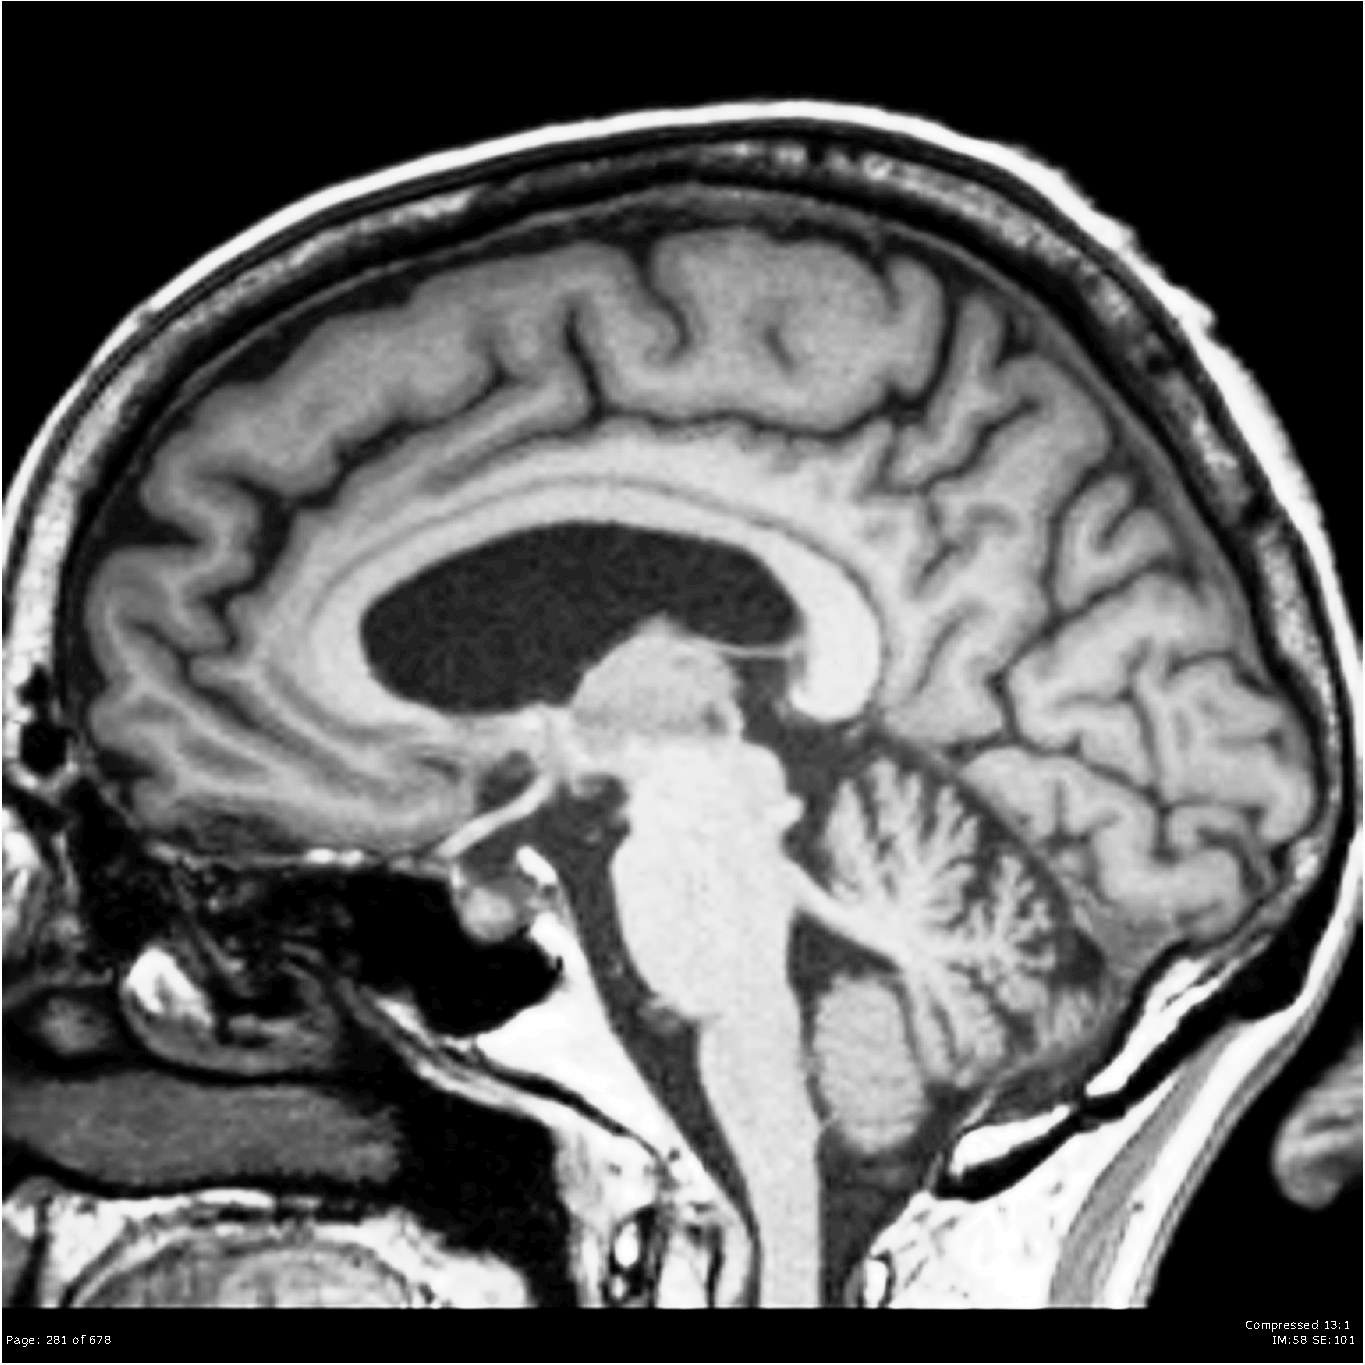

In [137]:
def histeq(im, nbr_bins = 256):
  """ Histogram equalization of a grayscale image.  """
  # get the image histogram
  imhist, bins = np.histogram(im.flatten(), nbr_bins, [0, 256])
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = imhist.max()*cdf/cdf.max()  #normalize
  cdf_mask = np.ma.masked_equal(cdf, 0)
  cdf_mask = (cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min())
  cdf = np.ma.filled(cdf_mask,0).astype('uint8')
  return cdf[im.astype('uint8')]

# apply the function on your dark image to increase the contrast
# we could observe that the contrast of the black background has increased
im5 = histeq(im4)
cv2_imshow(im5)

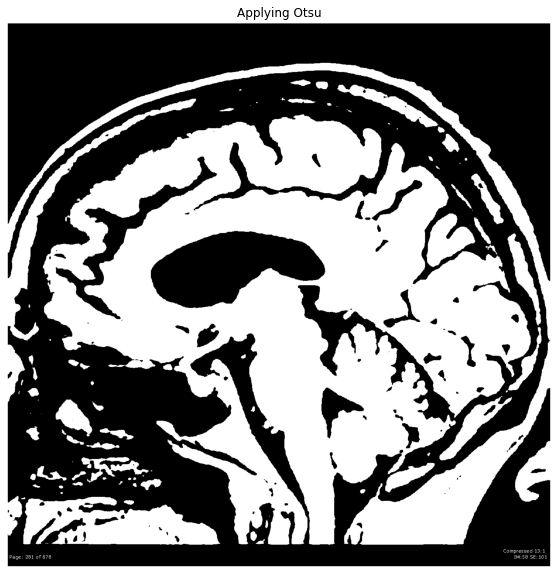

In [138]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Applying Otsu',thresh,'gray')

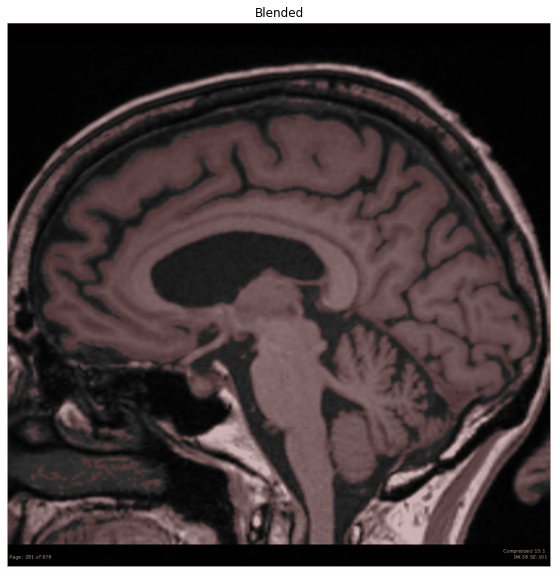

In [139]:
colormask = np.zeros(img.shape, dtype=np.uint8)
colormask[thresh!=0] = np.array((0,0,255))
blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
ShowImage('Blended', blended, 'bgr')

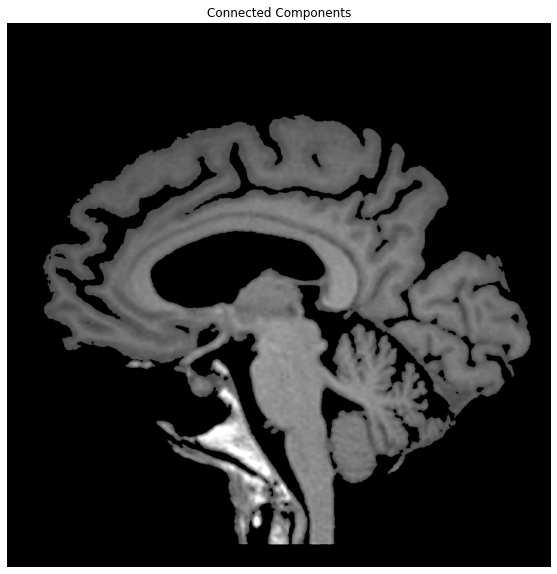

In [140]:
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
ShowImage('Connected Components',brain_out,'rgb')

In [141]:
im = Image.fromarray(brain_out)
im.save("brain_out.png")

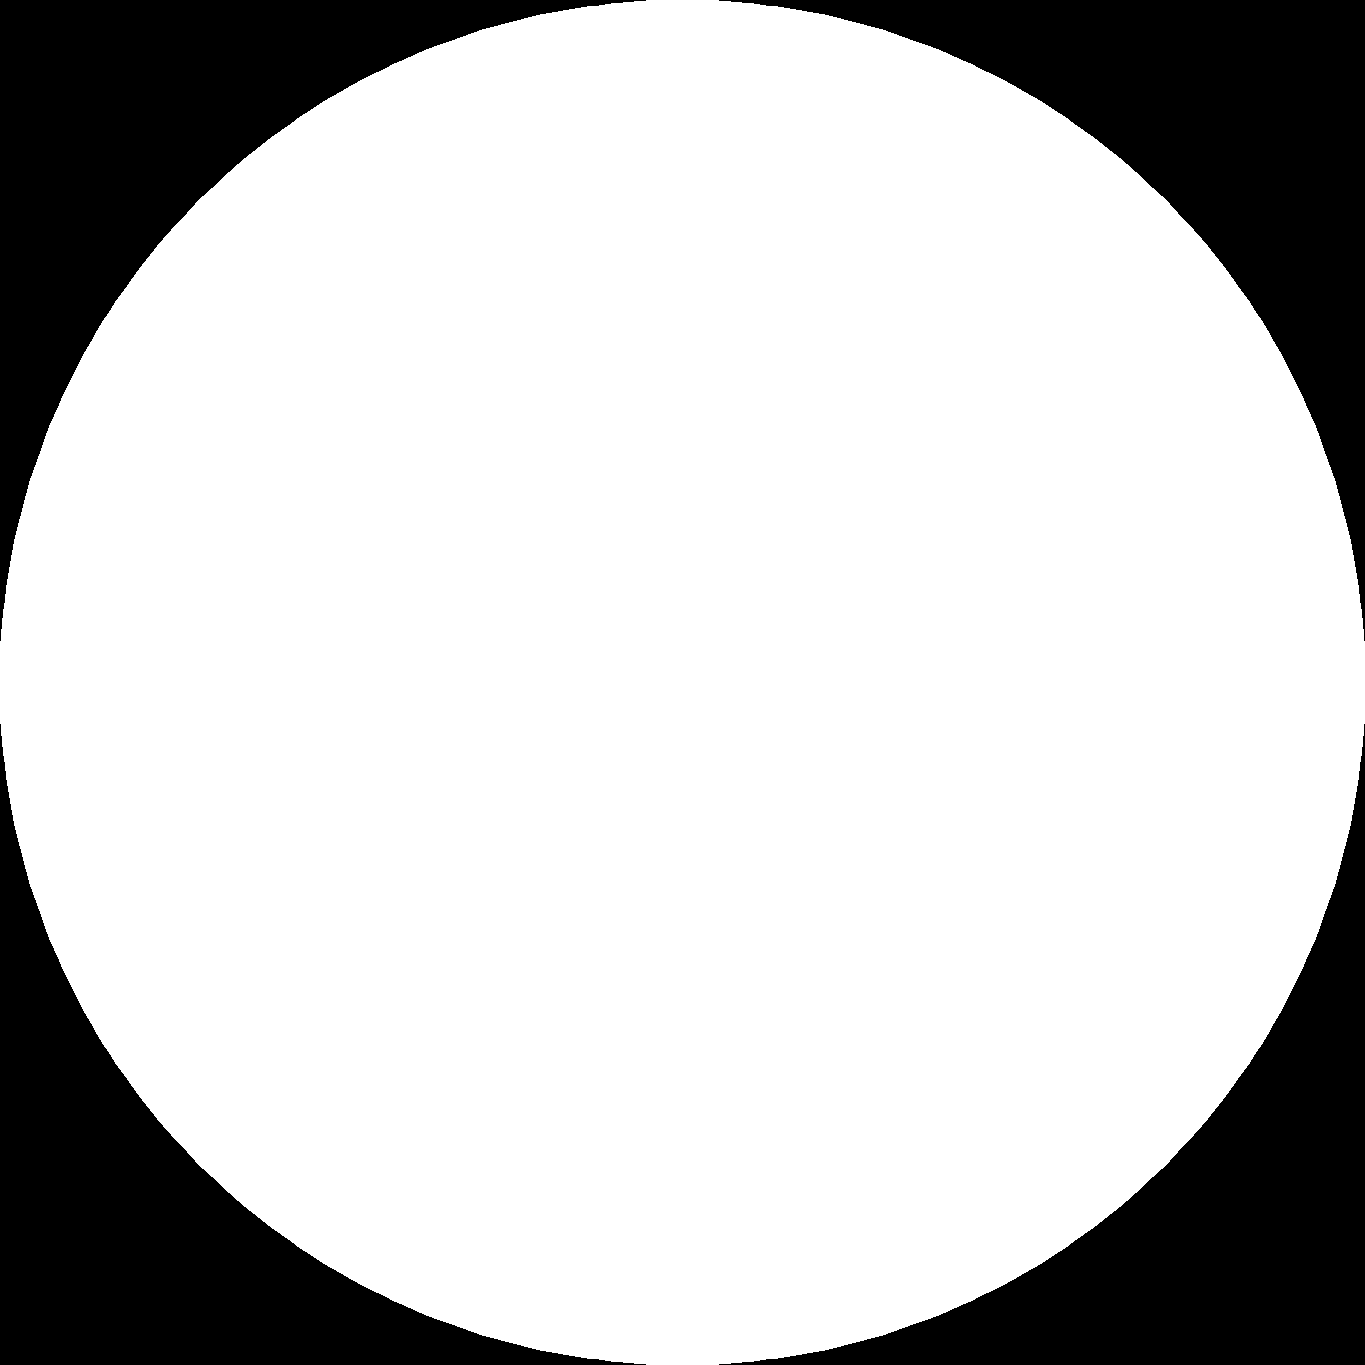

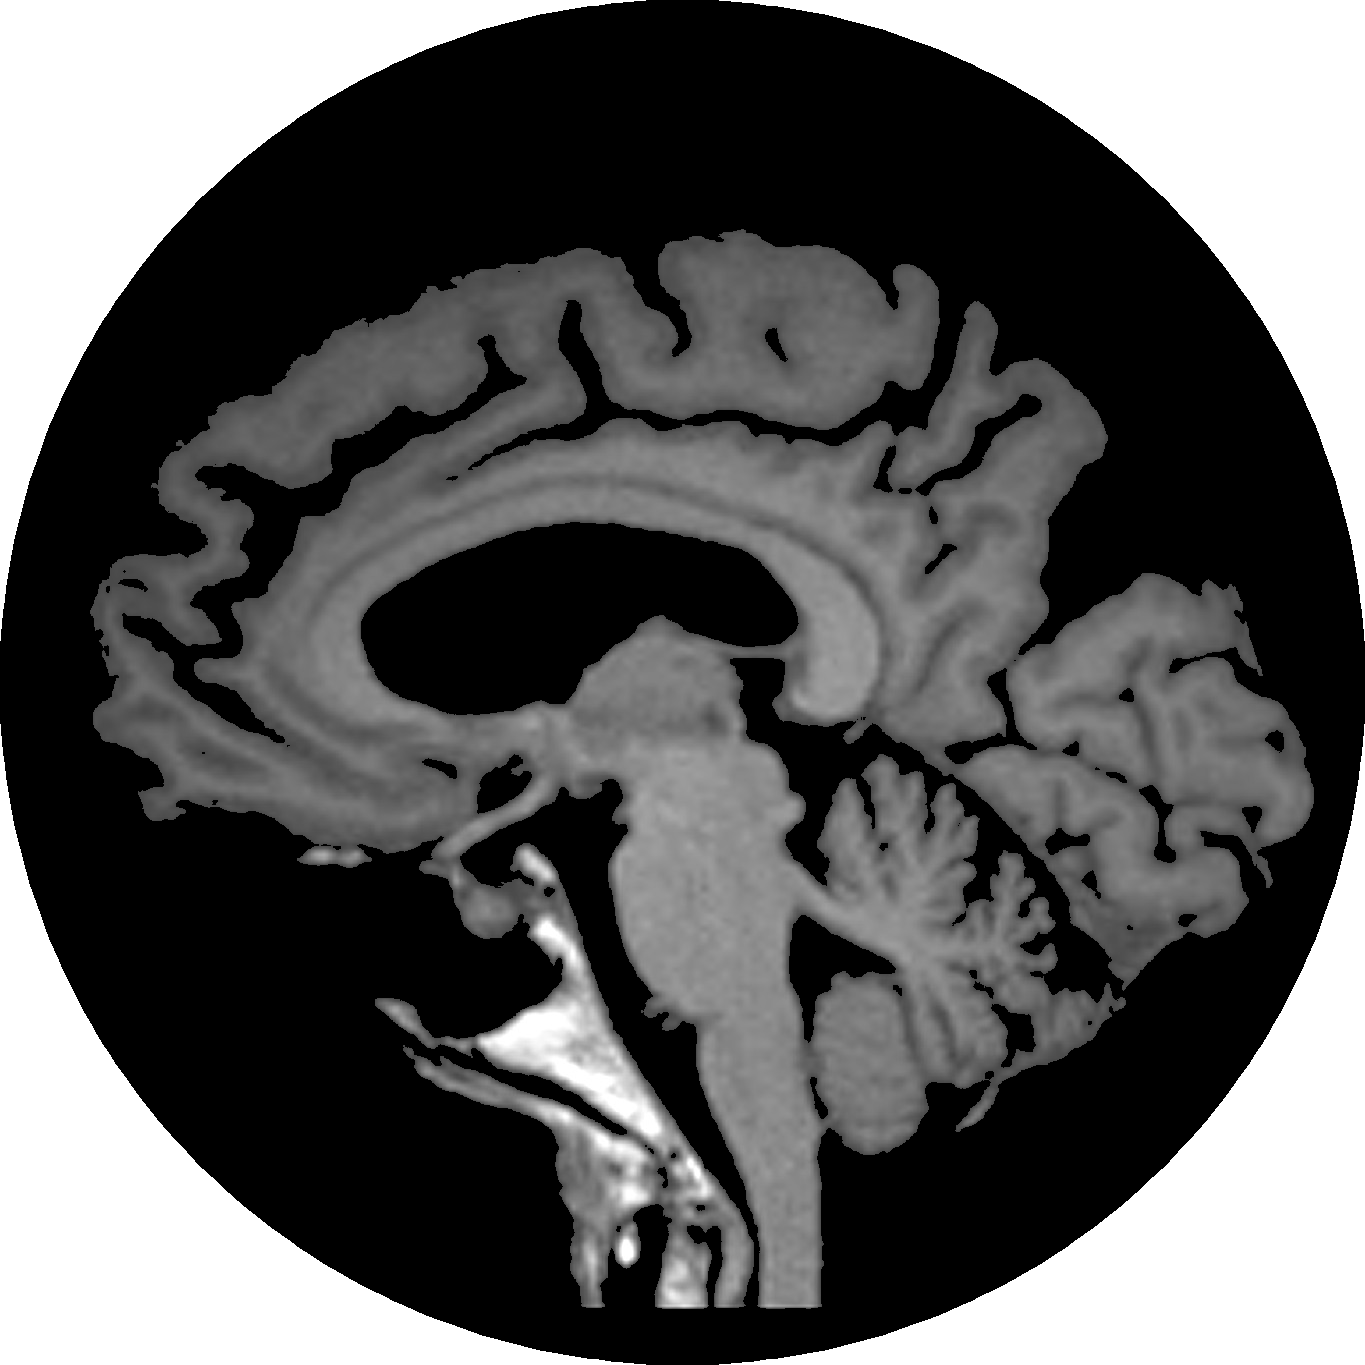

In [142]:
from PIL import Image, ImageDraw, ImageOps
img=Image.open("brain_out.png")

height,width = img.size
lum_img = Image.new('L', [height,width] , 0)
  
draw = ImageDraw.Draw(lum_img)
draw.pieslice([(0,0), (height,width)], 0, 360, 
              fill = 255, outline = "white")
img_arr =np.array(img)
lum_img_arr =np.array(lum_img)
display(Image.fromarray(lum_img_arr))
final_img_arr = np.dstack((img_arr,lum_img_arr))
im = Image.fromarray((final_img_arr))

display(im)

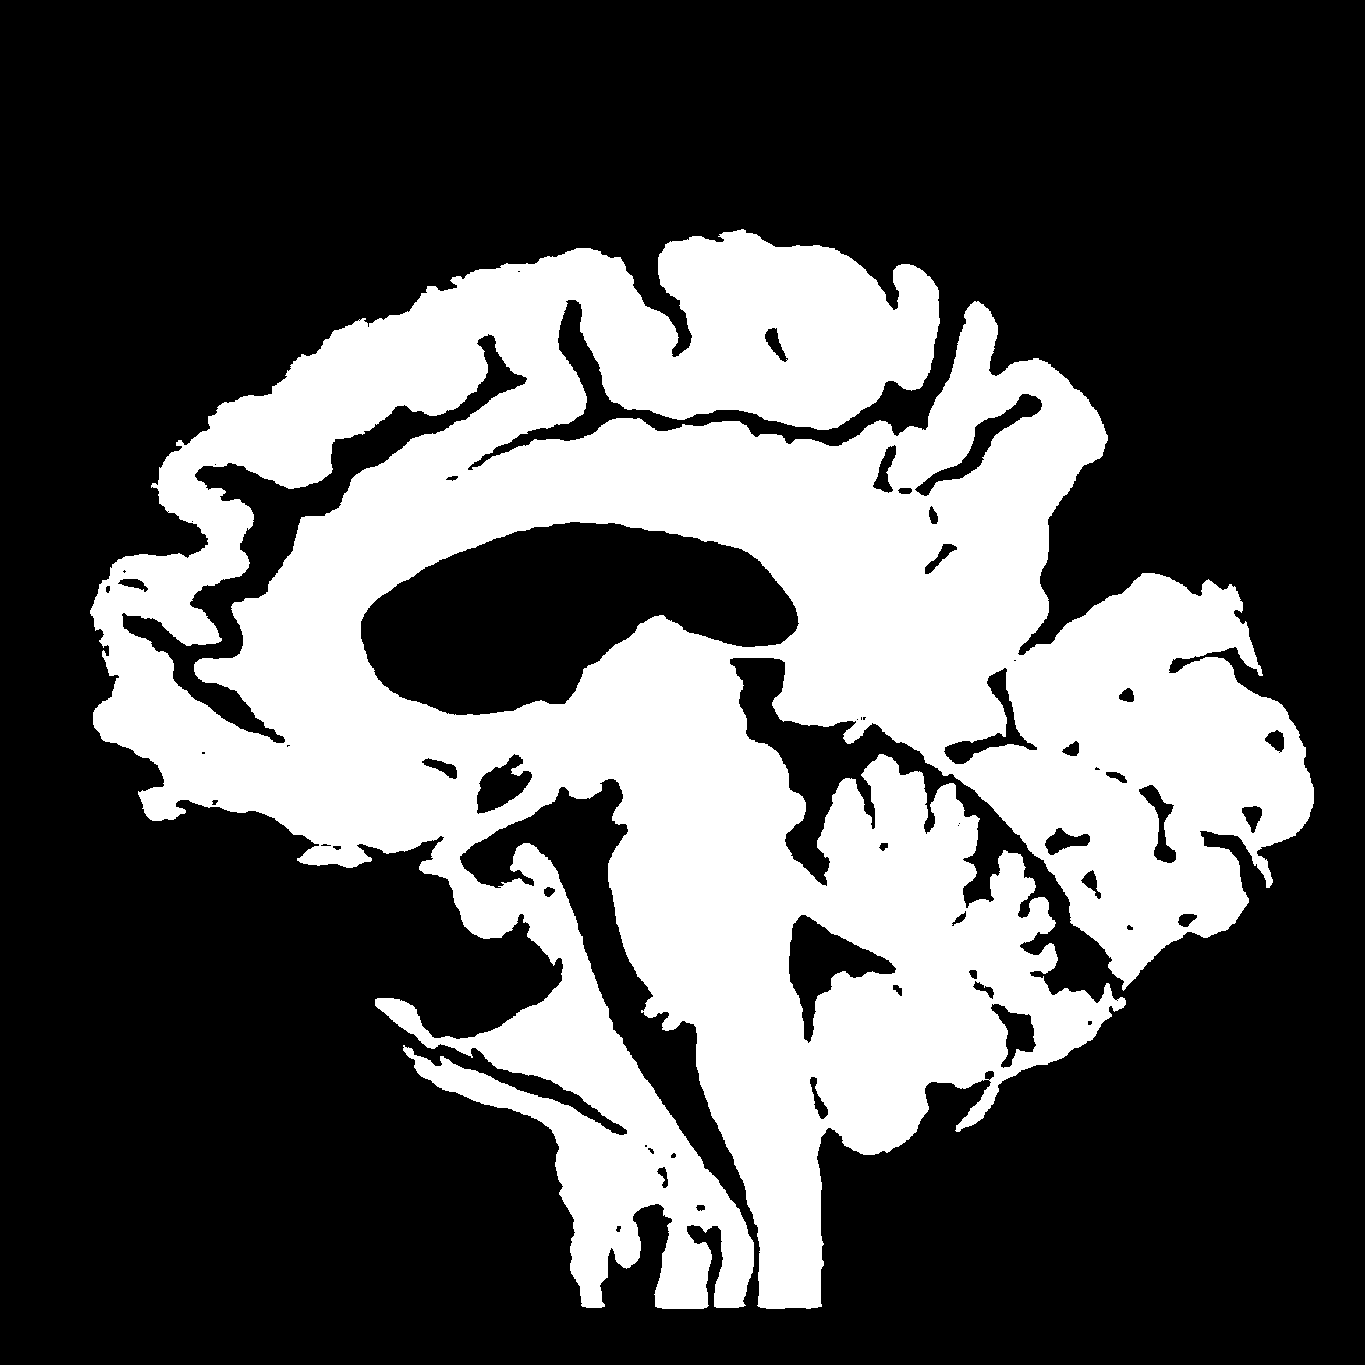

In [143]:
#black and white
import cv2
#1st time run the next line
grayImage = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2GRAY)
#grayImage = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY)
cv2_imshow(blackAndWhiteImage)

In [144]:
input = files.upload()

Saving img4.png to img4 (1).png


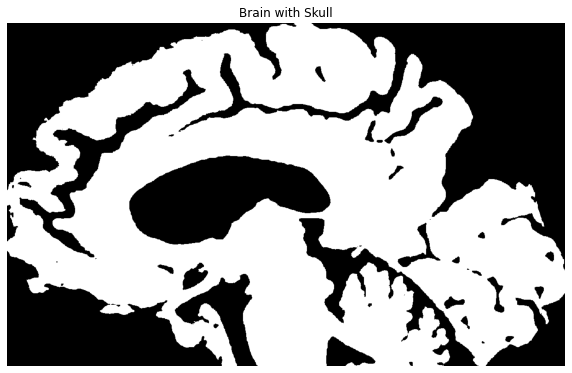

In [145]:
img           = cv2.imread('img4 (1).png')
gray          = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Brain with Skull',gray,'gray')

In [146]:
im = Image.fromarray(img)
im.save("blackAndWhiteImage.png")
from PIL import Image, ImageDraw, ImageOps
img=Image.open("blackAndWhiteImage.png")

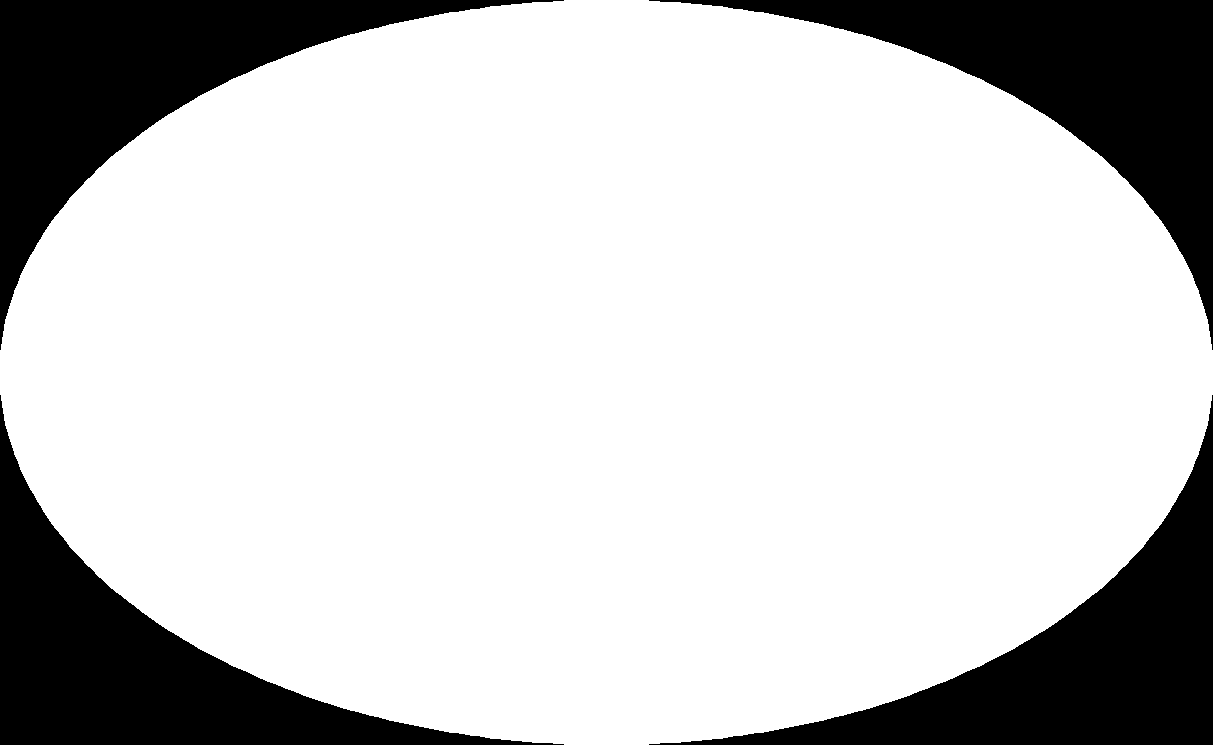

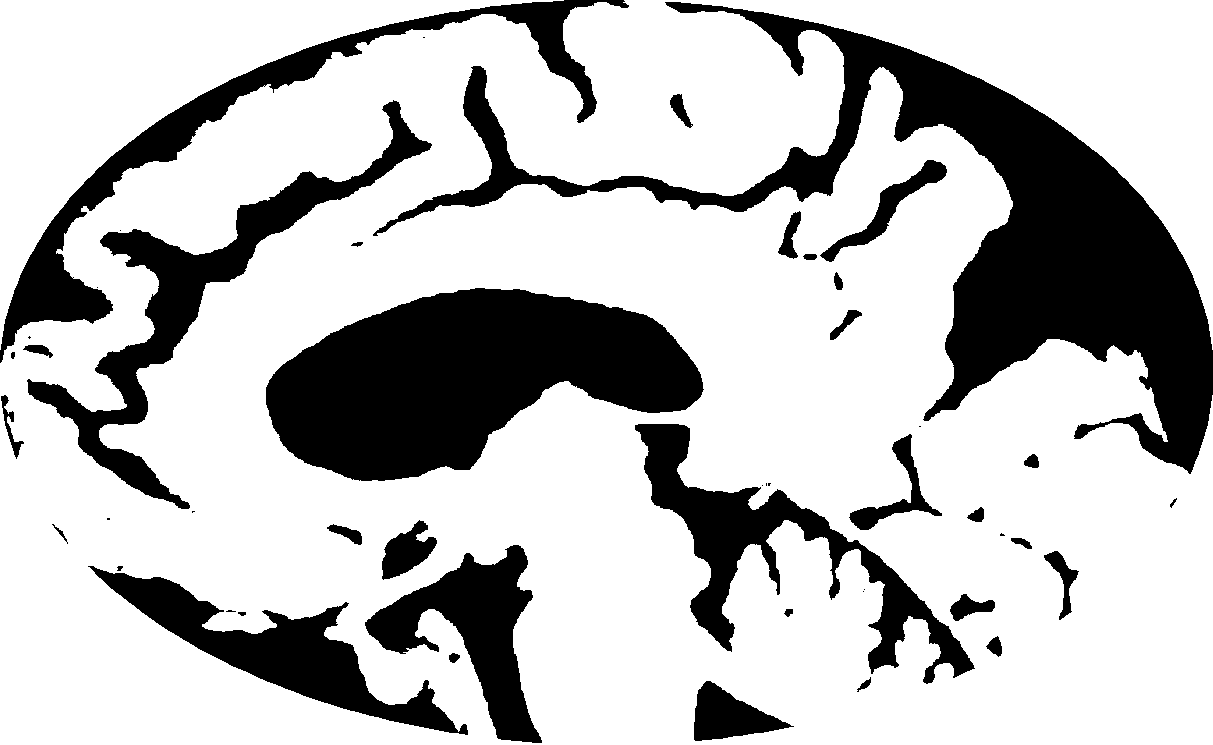

In [147]:
height,width =img.size
lum_img = Image.new('L', [height,width] , 0)
  
draw = ImageDraw.Draw(lum_img)
draw.pieslice([(0,0), (height,width)], 0, 360, 
              fill = 255, outline = "white")
img_arr =np.array(img)
lum_img_arr =np.array(lum_img)
display(Image.fromarray(lum_img_arr))
final_img_arr = np.dstack((img_arr,lum_img_arr))
im = Image.fromarray((final_img_arr))

display(im)

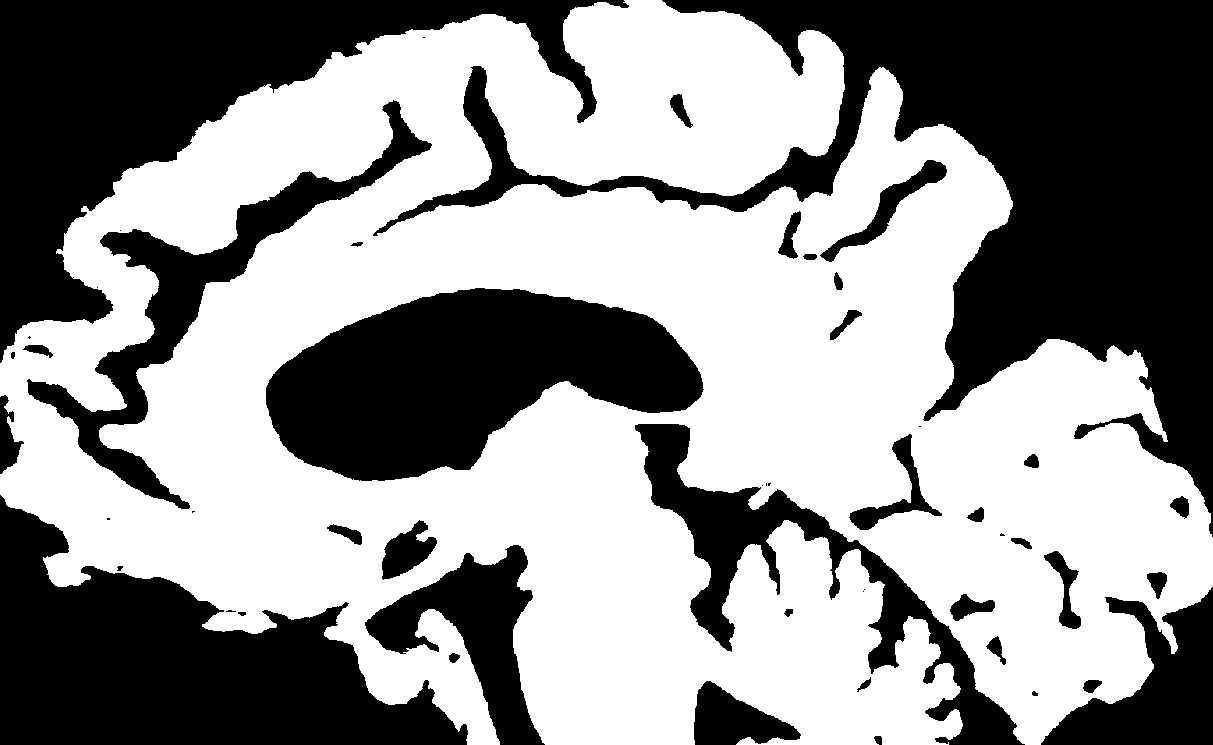

In [148]:
import cv2
#1st time run the next line
grayImage = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2GRAY)
#grayImage = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)
cv2_imshow(blackAndWhiteImage)

In [149]:
# importing libraries
import numpy as np
  
# reading the image data from desired directory
  
# counting the number of pixels
number_of_white_pix = np.sum(blackAndWhiteImage == 255)
number_of_black_pix = np.sum(blackAndWhiteImage == 0)
#number_of_white_pix = np.sum(im == 255)
#number_of_black_pix = np.sum(im == 10)
  
print('Number of white pixels:', number_of_white_pix)
print('Number of black pixels:', number_of_black_pix)

Number of white pixels: 510847
Number of black pixels: 392838
